# 1. ASP Project: Designing an Auto-Wah for guitar

Lucie Perrotta and Simon Guilloud

## 2. Abstract

In this project, we design and implement an Auto-Wah effect for music instruments. The Auto-Wah effect gained popularity in the early 70s as many rock guitar players and Jazz trumpet players used it live, allowing them to activate the pedal and move on the scene,  giving considerable practicality over the famous traditional Wah pedal which needs the player to tune-it using a foot switch while using it. On top of that it can variate much more rapidly than what a human can do. The Auto-Wah, as known as dynamic filter, is a time-varying bandpass filter, and is here synthetized using an IIR Dynamic Filter tuned according to the envelope of the signal: the louder the signal, the higher the peak and cutoff frequency of the lowpass filter.

## 3. Introduction

The Auto-Wah typically consists in a pedal plugged into the pedal rack of an instrument, before the signal is sent to an amplifier. Here, we implement a Python function that takes an audio recording as a numpy array, and returns a Wah filterd audio signal as a numpy array as well.

<img src="https://img.audiofanzine.com/images/u/product/normal/boss-aw-2-auto-wah-10485.jpg">


We first begin with the imports. We simply need the signal library from scipy (is case in it was not installed already, here is the installation line).

In [1]:
# Install libraries
! pip install scipy

The imports are the typical ones. We also use an helper file we wrote.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

# General imports
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython

# Audio imports
import scipy.signal as sgn
from scipy.io import wavfile

# Helpers
from helpers import *

### 3.1 The guitar sample we're working on

We will use a guitar sample to test our implementation. We first need to import it and to store it as a numpy array. We call this array "data". We also split it if it is stereo.

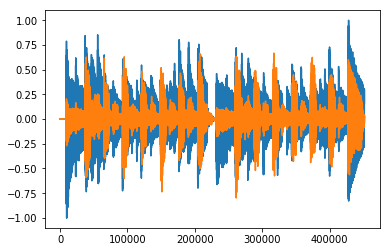

In [3]:
fs, data = wavfile.read('guitarstereo.wav') # get data as integers
if len(np.shape(data)) == 2 :
    datar = data[:,1]
    datal = data[:,0]
    MAX_VAL = abs(np.iinfo(datal.dtype).min)
    datal = datal / MAX_VAL 
    MAX_VAL = abs(np.iinfo(datar.dtype).min)
    datar = datar / MAX_VAL # now data is a normalized array of float between -1 and 1
    plt.plot(datal)
    plt.plot(datar)
    data = np.array([datal, datar])
    
else :
    MAX_VAL = abs(np.iinfo(data.dtype).min) # get max integer
    data = data / MAX_VAL # now data is a normalized array of float between -1 and 1
    plt.plot(data)

plt.show()
IPython.display.Audio(data, rate=fs)

## 4. Review of existing techniques (that we tried)

The aim of the Auto-Wah is to implement a time-dependent bandpass filtered signal, which center/cut-off frequency is tuned according to the envelope of the very signal. To this end, we explored several techniques which, while all functionnal, presented benefits and incovenients.

### 4.1 Audiolazy's resonator function

One simple but limited techniques would be to use a time-varying filters dedicated Python library, called audiolazy, which comes with several functions such as resonator. The resonator function takes as argument an array of center freqencies and an array of bandwith, corresponding to the value of the evolving freqency and bandwith over time. One initialized, the resonator function can hence be used with an audio stream as an input and produces another Stream as an output, which corresponds to the signal filtered according to the frequency and bandwith previously given.

Wiile the function worked pretty well for simple, slow varying signals, and reached aesthetical limits for more complex signals. The Stream format from Python also was poorly adapted to the practical use of the Auto-Wah function, which ideal took and return a numpy array. The code snippet below shows a typical implementation of the resonator function.

In [ ]:
# Code snippet only; DO NOT RUN !!!
from audiolazy import sHz, white_noise, line, resonator, AudioIO

s, Hz = sHz(fs)

sig = white_noise() # Endless white noise Stream

dur = 8 * s # Some few seconds of audio
freq = line(dur, 500, 2000) # A lazy iterable range
bw = (freq)/10

filt = resonator(freq * Hz, bw * Hz) # A simple bandpass filter

with AudioIO(True) as player:
  player.play(filt(sig), rate=fs)

bob = filt(sig)

### 4.2 STFT moving window with different bandpass filters

One obvious and theoretically appreciated technique is to cut the signal into lots of overlapping chunks, then to compute the average envelope value for each of these chunks, to then apply a static bandpass filter to each of them (accordingly to the mean envelope value) and finally to merge the chunks back together using the property of the overlap from the STFT. 

This method presents the weakness of being computationaly expensive and to be heard as not smooth enough depending on the chunk size. Ideally, we want the center frequency to move as smoothly as possible, here the center frenquency is always constant but fades in and out into another freqency, instead of actally changing from one to another.

In [ ]:
# Code snippet only; DO NOT RUN !!!

f, t, Zxx = sgn.stft(x=data, fs=fs, nperseg=1024) 
# nperseg = size of a chunk
# f = list of the freqs of the oscillators
# t = list of the starting times of the windows

Zxx = np.swapaxes(Zxx, 1, 0) 
# Zxx = list of the chunks, for each chunk, list of the DFT frequencies values

num_chunks = t.size # 50% overlap

# Chunk envelopes list: 1 mean envelope value per chunk
env_repr = np.asarray([envelope[int(t[i]*fs)] for i in range(num_chunks)])

### 4.3 IIR filter

A 3rd technique, and the one we have used, consists in implemeting an IIR filter, depending in both the envelope signal and the past values of the input signal itself, so that we keep a trace to the past values of the center frequency and compute the new center frequency accordingly. We generate a simple butterworth lowpass filter and add a peak at the cutoff freqency so that it behaves like a bandpass filter. The value of the singla is then computed according to the last values of the filtered signal, and the last and actual value of the raw signal.

The step by step implementation of this algorithm can be found at the next point.

## 5. Algorithm description

### 5.1 Compute the envelope of the signal

We first compute the envelope of the signal straight-forwardly. We pass the signal through an absolute value and smooth it so to keep only the low frequencies of it (avoid the small "noise"). Then, since the human auditory system's volume perception is not linear, but rather percieves audio levels on a logarithmic scale, we pass the envelope through an exponential. We then normalize the envelope between 0 and 1. We also cut the too high and too lew peaks to have more suitable floor and ceiling.

In [4]:
def compute_envelope (data, ma_width = 2000):
    """
    Compute the envelope of the signal for a dynamic filter application. It is just a moving average applied to the absolute value of the signal,
    normalized between 0 and 1 with some flooring/ceiling.
    Parameters:
    data = The audio signal, between -1 and 1
    ma_width = The width of the moving average.
    Return:
    The envelope of the signal, between 0 and 1
    """
    # Compute the envelope
    envelope = np.concatenate((np.zeros(ma_width//2), data, np.zeros(ma_width//2)))
    envelope = moving_average(np.abs(envelope), ma_width)
    # Log based auditory system
    envelope_log = np.exp(envelope)
    # Normalization
    envelope_log -= np.min(envelope_log)
    envelope_log /= np.max(envelope_log)
    # 
    envelopeF = envelope_log-np.percentile(envelope_log, 10)
    envelopeF /= np.percentile(envelope_log, 95)
    envelopeF = np.clip(envelopeF, 0, 1)
    envelopeF /= np.max(envelopeF)
    return envelopeF

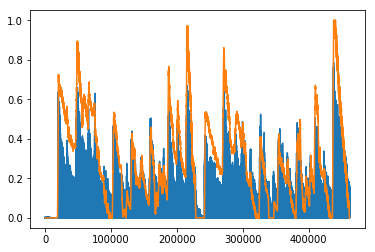

In [5]:
fs, data = wavfile.read('guitar.wav') # get data as integers
MAX_VAL = abs(np.iinfo(data.dtype).min) # get max integer
data = data / MAX_VAL # now data is a normalized array of float between -1 and 1
plt.plot(np.abs(data))
plt.plot(compute_envelope(data))

plt.show()

### 5.2 Auto-Wah using IIR Dynamic Filter

This method is the core of our implementation. It has quite a few parameters, but in case of doubt, base parameters should give fine results. First, ee calculate the envelope using the above methode. Then, we pad the signal with zeroes according to the order and the delay. Then we apply the filter dynamically. The filter's impulse response is only updated evey 100 samples to speed up execution, since the envelope doesn't change that fast. We chose is a lowpass butterworth filter because having tried everything, it's the one giving the best results. We apply the filter the standard way. Then we calculate and apply the resonnant (peak) the exact same way, and finally mix the two signals with coefficient p to have variable peak size.

In [6]:
def autowah(data, maximum, minimum, order=2, peak= True, Q = 1, p=0.8, delay=0, fs = 44100):
    """
    This function apply a dynamic filter (or autowah) on a given signal.
    Parameters:
    data = A numpy array containg audio values between -1 and 1
    maximum = The maximum value (in herz) the filter will cut too. Everything higher than that will always be cut.
    minimum = The minimum value (in herz) the filter will cut too. Everything lower than that will never be cut.
    order = The order of the IIR filter. 2 is fine. Try higher values if you want some weird techno-ish sounds
    peak = Boolean value. If set to false the filter will only be lowpass without the resonante component.
    Q = Quality factor of the peak.
    p = Height of the peak. It set to zero, equivalent to peak = False. Should be between 0 and 1 (included)
    delay = delay between the filter and the envelope. May give some weird result.
    fs = Sampling rate.
    
    Return :
    A numpy array containing the resulting audio signal, between 0 and 1.
    """
    if (order < 2):
        raise ValueError("order must be at least 2")
    envelope = compute_envelope(data)
    Q = max(Q, 0.5)
    if peak and (p>1 or p < 0):
        raise ValueError("p must be between 0 and 1")
    y = np.zeros(len(data)+ order+1)
    z = np.zeros(len(data)+ order+1)# Create the y (order + 1 zeros at the begining to compute the 1st values...)
    if delay > 0 :
        d = np.concatenate((np.zeros(order+1+int(delay*fs)), data)) # add padded zeros at the beginning
    else:
        d = np.concatenate((np.zeros(order+1), data, np.zeros(int(-delay*fs)))) # add padded zeros at the beginning
    envelope = np.concatenate((np.zeros(order+1), envelope))

    vals_b = np.zeros(order+1)
    vals_a = np.zeros(order+1)

    for i in range(order+1, len(y)): # begin at order+1 since we must use previous values (0)

        if(i%100 == order+1): 
            cutoff = envelope[i]*(maximum-minimum)/fs*2 + minimum/fs*2
            b, a = sgn.iirfilter(
                      N=order,
                      Wn=(cutoff),     
                      rp=30,
                      rs = 60,
                      btype='lowpass',
                      analog = False,
                      ftype='butter', 
                      output='ba')

        for j in range(0, order+1): # Compute X of the tranfer function
            vals_b[j] = b[j] * d[i-j]

        for j in range(1, order+1): # Compute Y of the tranfer function
            vals_a[j] = a[j] * y[i-j]

        y[i] = (1/a[0]) * ( np.sum(vals_b) - np.sum(vals_a) ) # Transfer function
        
    if peak :
        for i in range(3, len(z)): 

            if(i%100 == 3): # sinon trop lent
                cutoff = envelope[i]*(maximum-minimum)/fs*2 + minimum/fs*2
                b2, a2 = sgn.iirpeak(cutoff, Q)

            for j in range(0, 3): # Compute X of the tranfer function
                vals_b[j] = b2[j] * y[i-j]

            for j in range(1, 3): # Compute Y of the tranfer function
                vals_a[j] = a2[j] * z[i-j]

            z[i] = (1/a[0]) * ( np.sum(vals_b) - np.sum(vals_a) ) # Transfer function
        y = p*z+(1-p)*y
    return y/np.max(abs(y))

## 6. Results and discussion

This is the final function that one should eventually run to apply the Auto-Wah filter on a audio sample. It takes as argument: an input wav file, and low and high limits for the lowpass cutoff frequency, a peak variable activating or not the frequency boost peak at the center frequency, a power variable tuning the intensity of the peak, and finally a possitibilty to save the output audio signal as a wav file. The function returns a numpy array consisting in the filtered signal and the sampling frequency in order to play or use it. It is able to handle stereo files and applies the filter independently to left and right canal.

In [7]:
def renderAutowah (file, maximum = 3000, minimum = 500, peak = True, p = 1, write=False, output = "output.wav"):
    """
    This function apply a dynamic filter (or autowah) on a given wav file.
    Parameters:
    file = The filepath of a wav file.
    maximum = The maximum value (in herz) the filter will cut too. Everything higher than that will always be cut.
    minimum = The minimum value (in herz) the filter will cut too. Everything lower than that will never be cut.
    peak = Boolean value. If set to false the filter will only be lowpass without the resonante component.
    p = Height of the peak. It set to zero, equivalent to peak = False. Should be between 0 and 1 (included).
    write = Boolean value. Set to true if you want the resulting audio saved.
    output = The filepath where you want the result to be saved, if write = True.
    
    Return :
    A numpy array containing the resulting audio signal, between 0 and 1, along with the sampling rate of the file. Two-dimensional
    if stereo.
    """
    
    fs, data = wavfile.read(file) # get data as integers
    stereo = len(np.shape(data)) == 2
    if stereo :
        datar = data[:,1]
        datal = data[:,0]
        MAX_VAL = abs(np.iinfo(datal.dtype).min)
        datal = datal / MAX_VAL 
        MAX_VAL = abs(np.iinfo(datar.dtype).min)
        datar = datar / MAX_VAL # now data is a normalized array of float between -1 and 1
        yl = autowah(datal, maximum, minimum, peak = peak, Q = 0.8, p = p, delay = 0)
        yr = autowah(datar, maximum, minimum, peak = peak, Q = 0.8, p = p, delay = 0)
        y = np.asarray([yl, yr], dtype=np.float32)
        
    else :
        MAX_VAL = abs(np.iinfo(data.dtype).min) # get max integer
        data = data / MAX_VAL # now data is a normalized array of float between -1 and 1
        y = autowah(data, maximum, minimum, peak = peak, Q = 0.8, p = p, delay = 0)
        y = np.asarray(y, dtype=np.float32)
    if write :
        wavfile.write(output, fs, y)
    return y, fs

We can finally listen to the Wah filtered signal!

In [8]:
y, fs = renderAutowah("guitar.wav", maximum = 3223, minimum = 336, peak = True, p = 1)
#plt.plot(y) dont try to plot a stereo (2D) signal without splitting it, it takes forever
IPython.display.Audio(y, rate=fs)

In [9]:
y2, fs = renderAutowah("guitarstereo.wav", maximum = 3223, minimum = 336, peak = True, p = 1)
#plt.plot(y) dont try to plot a stereo (2D) signal without splitting it, it takes forever
IPython.display.Audio(y2, rate=fs)

## 7. Conclusion

Having tried multiple approaches, we're confident that the IIR is the way to go. Not only is it probably the fastest way to apply the algorithm, but it also is adequate if we ever wanted to adapt our algorithm to real-time applications. From a sound point of view, we're pretty satisfied with the result. We can clearly hear the sweep effect on the notes. There is also no audible glitch, and the signal is realtively untouched beside the sweeping effect. We were able to implement a lot of parameters, and even though we couldn't test every possible combinations, we're confident that the values we use give satisfying result.
If this would ever be improved, the next steps would be to have it work in real time, possibly making a VST plugin. That is beyond the scope of this project however.

## 8. Bibliography

https://pypi.org/project/audiolazy/

https://stackoverflow.com/questions/18128057/applying-time-variant-filter-in-python

https://medias.audiofanzine.com/files/aw-2-manual-476138.pdf

https://www.youtube.com/watch?v=Dp1s0Ow2BJU&t=1188s